# Code for analyzing volume output
- Uses CSV generated by "collect_volumes.sh" script part of [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes) 


- 5 atlases, 15 templates, 47 subjects found
- 72 atlas-to-template registration commands left
- 705 template-to-subject registration commands left
- 3525 transform merging commands left
- 3525 label propagation commands left
- 47 label fusion commands left




In [1]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import nibabel as nib

### Paths

In [14]:
project_dir = '../../../'
data_dir = project_dir + 'data/preproc_T1s/'
results_dir = '../results/MAGeT/'

### Grab total brain volumes from the masks

In [15]:
groups = ['NC','ET']
grp = 'NC'

mask_dir = data_dir + '{}/masks/'.format(grp)

mask_paths = os.listdir(mask_dir)
mask_df = pd.DataFrame(columns=['Subject','brain_volume'])
for m, mask_path in enumerate(mask_paths):
    sub_name = mask_path.rsplit('-',1)[0]
    mask_path = mask_dir + sub_name + '-brain_mask.nii.gz' 
    
    # load anothor image to mask
    mask = nib.load(mask_path)
    mask_data = mask.get_data()
    mask_df.loc[m] = [sub_name.split('_',1)[0],np.sum(mask_data.ravel())]

mask_df.head()

,Subject,brain_volume
0,sub-4300,1420840
1,sub-0016,1475141
2,sub-0081,1319141
3,sub-7000,1326417
4,sub-1450,1349853


### Grab cerebellum volumes from segmentations

In [18]:

cols_L = ['L_I_II', 'L_III', 'L_IV', 'L_V', 'L_VI', 'L_Crus_I','L_Crus_II', 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X', 'L_CM']
cols_R = ['R_I_II', 'R_III', 'R_IV', 'R_V', 'R_VI', 'R_Crus_I', 'R_Crus_II','R_VIIB', 'R_VIIIA', 'R_VIIIB', 'R_IX', 'R_X', 'R_CM']
grp = groups[0]

vol_df = pd.read_csv('{}{}_volumes.csv'.format(results_dir,grp))
vol_df['group'] = grp
vol_df['Subject'] = vol_df['Subject'].str.split('_',expand=True)[0].str.split('/',expand=True)[1]
vol_df['Total_L'] = vol_df[cols_L].sum(axis=1)
vol_df['Total_R'] = vol_df[cols_R].sum(axis=1)

vol_df = pd.merge(vol_df,mask_df,on='Subject',how='left')
vol_df.head()

,Subject,L_I_II,L_III,L_IV,L_V,L_VI,L_Crus_I,L_Crus_II,L_VIIB,L_VIIIA,...,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X,R_CM,group,Total_L,Total_R,brain_volume
0,sub-0061,54.0,831.0,2519.0,3625.0,7201.0,10349.0,7570.0,3509.0,5316.0,...,4871.0,3928.0,3239.0,2699.0,513.0,7526.0,ET,54314.0,57865.0,1400053
1,sub-0016,75.0,979.0,2700.0,4822.0,8896.0,11257.0,9249.0,3517.0,6107.0,...,5421.0,4448.0,3894.0,4662.0,599.0,7896.0,ET,64478.0,67298.0,1475141
2,sub-0081,125.0,895.0,2316.0,3468.0,6315.0,11410.0,6663.0,2828.0,5304.0,...,4776.0,3606.0,3250.0,2911.0,632.0,6759.0,ET,53619.0,57589.0,1319141
3,sub-0115,56.0,744.0,2294.0,3441.0,5420.0,9979.0,7227.0,3205.0,5493.0,...,4657.0,3883.0,3039.0,3486.0,554.0,6684.0,ET,51463.0,54601.0,1245352
4,sub-0119,81.0,761.0,2063.0,3946.0,7193.0,11504.0,5921.0,2631.0,5290.0,...,4205.0,3689.0,3378.0,2805.0,539.0,7418.0,ET,53280.0,56064.0,1340808


## Plots

### Total volumes
- Cerebellum (L and R) compared with TBV

Normalizing cerebellum volume with TBV


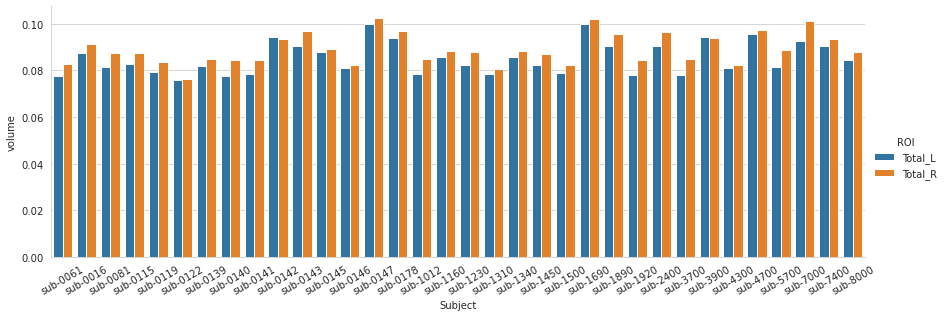

In [22]:
plot_df = vol_df.copy()
plot_df[['Subject','group','Total_L','Total_R','brain_volume']]

normalize = True

if normalize:
    print('Normalizing cerebellum volume with TBV')
    plot_df['Total_L'] = plot_df['Total_L']/(0.5*plot_df['brain_volume'])
    plot_df['Total_R'] = plot_df['Total_R']/(0.5*plot_df['brain_volume'])

with sns.axes_style("whitegrid"):
    plot_df = pd.melt(plot_df, id_vars = ['Subject','group','brain_volume'], value_vars = ['Total_L','Total_R'] , 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(y='volume', x='Subject', hue='ROI', kind='bar',aspect=3, height=4,
                    data=plot_df)
    g.set_xticklabels(rotation=30)

### ROI volumes

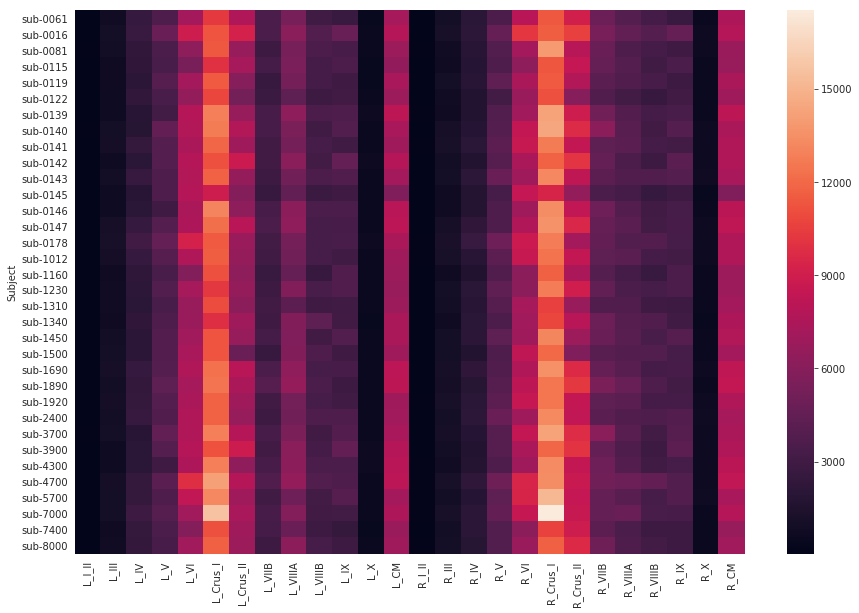

In [77]:
plot_df = vol_df.copy()
plot_df = plot_df.set_index('Subject')
plot_df = plot_df[cols_L + cols_R ]
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    g = sns.heatmap(plot_df)

### Group comparisons

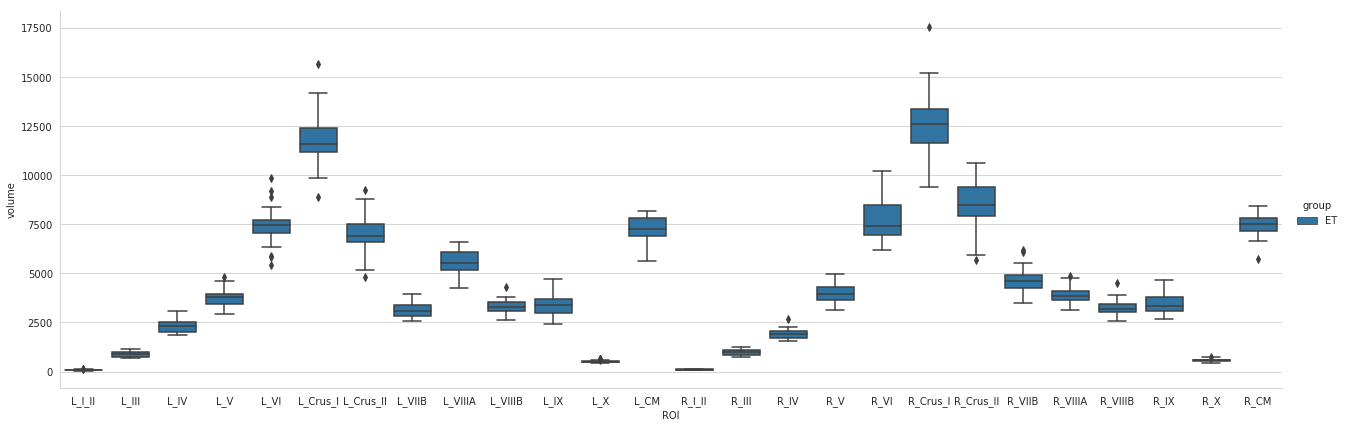

In [75]:
plot_df = vol_df.copy()
plot_df = plot_df[['Subject','group'] + cols_L + cols_R]
with sns.axes_style("whitegrid"):
    plot_df = pd.melt(plot_df, id_vars = ['Subject','group'], value_vars = cols_L + cols_R, 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(y='volume', x='ROI', hue='group', kind='box',aspect=3, height=6,
                    data=plot_df)

 

In [ ]:
# 145 - undersegmented
# 1690 - oversegmented